In this notebook we are oging to take the FID from an NMR and graph it as an NMR spectrum. As you can see below, I'm importing the usual packages, but I've also imported one we haven't used before. The nmrglue package is an open-source package for analyzing and graphing nmr spectra, and probably isn't preinstalled in your version of python. To install it, check out the [nmrglue install guide](https://nmrglue.readthedocs.io/en/latest/install.html).

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import nmrglue as ng

The nice thing about the nmrglue package is that it lets me import data using the proprietary files created by the NMR system. For example, I can use the read_fid() function in the nmrglue package to read agilent nmr files, without having to turn them into an open-source data file first.

In [15]:
dic, data = ng.fileio.agilent.read_fid("/Users/erikmenke/UC-Merced/Computations/JupyterNotebooks/NMR sample/NoD2O/NoD2O_fid", shape=None)
params = ng.fileio.agilent.read_procpar("/Users/erikmenke/UC-Merced/Computations/JupyterNotebooks/NMR sample/NoD2O/NoD2O_procpar")


/anaconda/lib/python3.6/site-packages/nmrglue/fileio/varian.py:709: UserWarning: unknown shape, returning unshaped data
  warn("unknown shape, returning unshaped data")


You can see that I get a warning, but as we'll see it doesn't affect anything, so I think it's safe to ignore. Now that I've read in the fid and parameter file, I can start to work with it. First, as I'm sure you remember, the data that the NMR collects is the free induction decay, or FID. What does that look like?

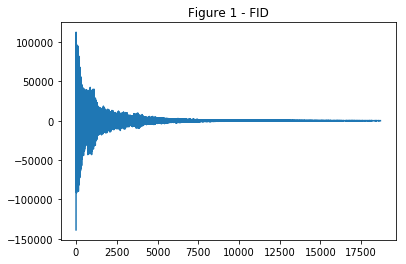

In [16]:
plt.plot(data.real[0])
plt.title("Figure 1 - FID")
plt.show()

There's the FID. Unfortunately there are a couple of problems. The biggest is that the x-axis is wrong. The way Agilent (and most NMR data files) stores FID data is as a series of values, and so when we graph that data the x-axis is the point number. However, the x-axis should be time, not point number, so we have to create an array of points with the value of time that each data point was collected. To do this, we can look at the total acquisition time of the FID and the total number of points to find the time per point, and then use that to create an array of times. The acquisition time is stored as "at" in the "params" array that I imported, above. And no, I didn't know how to do this when I started. I had to spend a fair bit of time reading the nmrglue documentation and looking at examples on the internet.

In [17]:
acq_time = float(params['at']['values'][0])
time_per_point = acq_time/(data.shape[1])
time=np.arange(0,acq_time,time_per_point)
print("The FID acquisition took " + "{:1.5}".format(acq_time) + " seconds.")

The FID acquisition took 2.6001 seconds.


Now let's look at the FID with the correct x-axis.

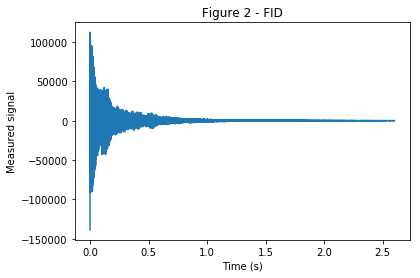

In [18]:
plt.plot(time,data.real[0])
plt.title("Figure 2 - FID")
plt.xlabel('Time (s)')
plt.ylabel('Measured signal')
plt.show()

Turns out, in FT-NMRs there are two reciever antennaes, one along the x-axis of the NMR and one along the y-axis of the NMR, and each antennae collects an FID. One is stored as "real" and the other is stored as "imaginary", but these names are just mathematical convenience. The FID above is the one stored as the real. What does the one stored as imaginary look like?

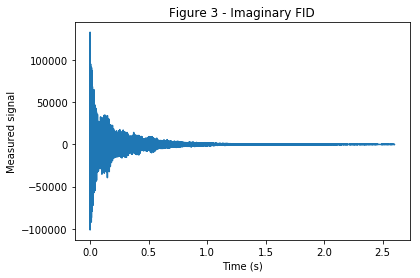

In [19]:
plt.plot(time,data.imag[0])
plt.title("Figure 3 - Imaginary FID")
plt.xlabel('Time (s)')
plt.ylabel('Measured signal')
plt.show()

I don't see any difference between the two, but rest assured, they are different. To turn the FID into a useful spectrum that we can analyze by eye, we have to Fourier transform it. Luckily, the numpy package has a Fourier transform function called fft() (for Fast Fourier Transform).

In [20]:
fftdata = np.fft.fft(data)

Let's take a look at our NMR spectrum!

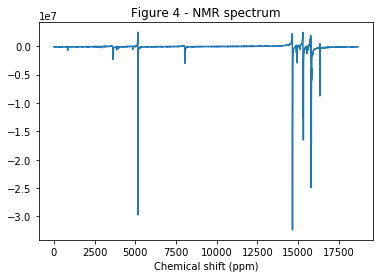

In [21]:
plt.plot(fftdata.real[0])
plt.title("Figure 4 - NMR spectrum")
plt.xlabel("Chemical shift (ppm)")
plt.show()

Well, that doesn't seem quite right. For a proton NMR we typically expect chemical shifts between 0 and 10, not 17,500. And the peaks are mostly pointing down and have weird edge effects. What went wrong? Nothing, actually, we're just not done yet. First, when we Fourier transform the FID, our x-axis goes from time (s) to frequency (s$^{-1}$), and we have to do an extra step to turn it into chemical shift (ppm). Also, we need to remember that our data is stored as points without time, so we need to also use the fft() function on our time array to create the correct x-axis.

In [22]:
NMR_freq = 400
freq = np.fft.fftfreq(time.shape[0],time_per_point)
chem_shift = -(freq - 1986)/NMR_freq

After multiple tries I was able to figure out that the TMS peak was at a frequency value of 1986, and so I subtracted that from the frequency to get the TMS peak at zero. So, what does the spectrum look like now?

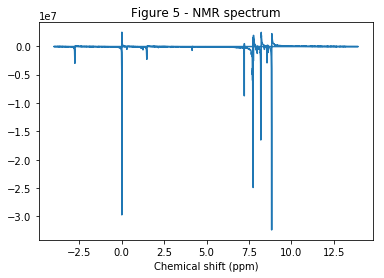

In [26]:
plt.plot(chem_shift,fftdata.real[0])
plt.title("Figure 5 - NMR spectrum")
plt.xlabel("Chemical shift (ppm)")
plt.show()

It's starting to look better, but we still have two issues. The first, which is minor, is that standard NMR spectra convention is to have the positive chemical shifts to the left, rather than the right, so we'll need to fix our axis. The seconds, which is a bigger issue, is that the peaks still look odd. This is where the real vs. imaginary FIDs become important. Right now we are only graphing the Fourier transformed real FID, and the result is that our peaks are out of phase with the detector. So we need to combine the real and imaginary data to get everything in phase. If you've messed with the phase setting on the NMR, this is what you are changing. Here, we need to change the phase by hand. Mathematically, this works out to be the real data times $\cos{\theta}$ + imaginary data times times $\sin{\theta}$, where we need to find theta. After multiple tries I found that a good value for $\theta$ is 10.

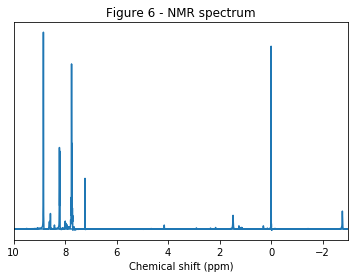

In [24]:
theta = np.degrees(10)
plt.plot(chem_shift,fftdata.real[0]*np.cos(np.radians(theta)) + fftdata.imag[0]*np.sin(np.radians(theta)))
ax = plt.gca()
ax.set_xlim(-3,10)
ax.set_xlim(ax.get_xlim()[::-1])
ax.axes.yaxis.set_ticklabels([])
ax.axes.yaxis.set_ticks([])
plt.title("Figure 6 - NMR spectrum")
plt.xlabel("Chemical shift (ppm)")
plt.show()

And there we have it, the NMR spectrum. If you want, play around with different $\theta$ values to see how that affects the graph. Now, your job is to graph the NMR for the other FID on CatCourses, and compare it to the spectrum above. The spectrum you are graphing is for the same material as above, but *after* D$_{2}$O has been added to the NMR tube.

What are the differences between the two spectra? What can you say about the material, knowing that the change was due to the addtion of D$_{2}$O?

**Answer here**